In [68]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import re
import numpy as np
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from spellchecker import SpellChecker
from tqdm import tqdm
import codecs
import tensorflow
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM,Dropout,Bidirectional
from keras.layers.embeddings import Embedding
from keras.initializers import Constant

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Matt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Matt\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [69]:
## Loading the data
df = pd.read_csv('data/train.csv',encoding='utf-8')
holdout = pd.read_csv('data/test.csv',encoding='utf-8')
df.head(7)
holdout.shape

(3263, 4)

# Data Preprocessing
 1. Remove URL 
 2. Remove emojis 
 3. Remove Contractions 
 4. Remove Punctuations
 5. Remove Stopwords

In [70]:
def preprocess_clean_data(text):
    
    #remove urls
    urls = re.compile(r'https?://\S+|www\.\S+')
    text_without_https =  urls.sub(r'',text)
    url = re.compile(r'http?://\S+|www\.\S+')
    text_without_url =  url.sub(r'',text_without_https)


    #remove emojis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text_without_emoji =  emoji_pattern.sub(r'', text_without_url)

    #remove contractions
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'll": "i will",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'll": "it will",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "must've": "must have",
    "mustn't": "must not",
    "needn't": "need not",
    "oughtn't": "ought not",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "she'd": "she would",
    "she'll": "she will",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "that'd": "that would",
    "that's": "that is",
    "there'd": "there had",
    "there's": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "where'd": "where did",
    "where's": "where is",
    "who'll": "who will",
    "who's": "who is",
    "won't": "will not",
    "wouldn't": "would not",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are",
    "thx"   : "thanks"
    }


    temp = text_without_emoji.split()
    text_without_contractions =''
    for wrd in temp:
        if wrd.lower() in contractions:
            replaced_word = contractions[wrd.lower()] + ' '
        else:
            replaced_word = wrd + ' '
        text_without_contractions  = text_without_contractions + replaced_word
    text_without_contractions =  text_without_contractions.strip()



    #remove punctuation
    table=str.maketrans('','',string.punctuation)
    clean_text =  text_without_contractions.translate(table)

    return clean_text

df['text']=df['text'].apply(preprocess_clean_data)
holdout['text']=holdout['text'].apply(preprocess_clean_data)

## Word Tokenization

In [71]:
train_tweets = list()
holdout_tweets = list()
lines =df['text'].values.tolist()
spell = SpellChecker()

#tokenizing words and doing some more cleaning like removing stop words and correcting spellings
for line in tqdm(lines):
  token = word_tokenize(line)
  token = [word.lower() for word in token]
  tokens_without_sw = [word for word in token if not word in stopwords.words()]
  token_stopped = [word for word in tokens_without_sw if word.isalpha()]
  misspelled = spell.unknown(token_stopped)
  final_token = list()
  for w in token_stopped:
        if w in misspelled:
            final_token.append(spell.correction(w))
        else:
            final_token.append(w)
  train_tweets.append(final_token)

#Applying same logic to holdout set
lines =holdout['text'].values.tolist()
for line in tqdm(lines):
  token = word_tokenize(line)
  token = [word.lower() for word in token]
  tokens_without_sw = [word for word in token if not word in stopwords.words()]
  token_stopped = [word for word in tokens_without_sw if word.isalpha()]
  misspelled = spell.unknown(token_stopped)
  final_token = list()
  for w in token_stopped:
        if w in misspelled:
            final_token.append(spell.correction(w))
        else:
            final_token.append(w)  
  holdout_tweets.append(final_token)
    
    
print(train_tweets[:3])
print(len(train_tweets))
print("---------")
print(holdout_tweets[:3])
print(len(holdout_tweets))



  2%|▏         | 161/7613 [02:05<32:36,  3.81it/s]


  4%|▍         | 319/7613 [04:11<1:37:59,  1.24it/s]


  6%|▌         | 475/7613 [06:05<52:06,  2.28it/s]  


  8%|▊         | 632/7613 [08:12<3:25:18,  1.76s/it]


 10%|█         | 789/7613 [10:54<1:08:12,  1.67it/s]


 12%|█▏        | 945/7613 [13:36<5:08:47,  2.78s/it]


 14%|█▍        | 1101/7613 [15:31<2:48:31,  1.55s/it]


 17%|█▋        | 1298/7613 [16:33<15:59,  6.58it/s]


 20%|█▉        | 1486/7613 [17:43<24:33,  4.16it/s]


 22%|██▏       | 1684/7613 [18:45<22:31,  4.39it/s]


 25%|██▍       | 1885/7613 [19:52<30:58,  3.08it/s]


 27%|██▋       | 2080/7613 [21:11<45:36,  2.02it/s]  


 30%|██▉       | 2272/7613 [22:19<20:23,  4.36it/s]


 32%|███▏      | 2458/7613 [23:37<28:52,  2.98it/s]


 35%|███▍      | 2641/7613 [24:54<22:27,  3.69it/s]


 37%|███▋      | 2824/7613 [26:15<28:09,  2.83it/s]


 40%|███▉      | 3027/7613 [27:17<16:03,  4.76it/s]


 42%|████▏     | 3224/7613 [28:25<17:01,  4.30it/s]


 45%|████▍     | 3416/7613 [29:20<17:20,  4.03it/s]


 48%|████▊     | 3625/7613 [30:18<16:12,  4.10it/s]


 50%|█████     | 3839/7613 [31:37<54:07,  1.16it/s]


 53%|█████▎    | 4021/7613 [32:38<32:41,  1.83it/s]


 56%|█████▌    | 4235/7613 [33:50<1:16:45,  1.36s/it]


 58%|█████▊    | 4421/7613 [34:55<23:58,  2.22it/s]


 61%|██████    | 4624/7613 [36:05<17:03,  2.92it/s]


 63%|██████▎   | 4815/7613 [37:09<13:25,  3.47it/s]


 66%|██████▌   | 4997/7613 [38:57<16:14,  2.68it/s]


 68%|██████▊   | 5183/7613 [40:26<12:01,  3.37it/s]


 70%|███████   | 5365/7613 [41:45<31:24,  1.19it/s]


 73%|███████▎  | 5554/7613 [42:56<12:02,  2.85it/s]


 75%|███████▌  | 5742/7613 [44:16<08:49,  3.53it/s]


 78%|███████▊  | 5915/7613 [45:28<06:39,  4.25it/s]


 80%|████████  | 6110/7613 [46:50<16:52,  1.49it/s]


 83%|████████▎ | 6298/7613 [48:07<07:47,  2.81it/s]


 85%|████████▌ | 6478/7613 [49:15<04:37,  4.09it/s]


 88%|████████▊ | 6666/7613 [50:37<07:19,  2.15it/s]


 90%|████████▉ | 6846/7613 [51:45<06:08,  2.08it/s]


 92%|█████████▏| 7017/7613 [53:07<07:21,  1.35it/s]


 94%|█████████▍| 7188/7613 [54:34<02:56,  2.41it/s]


 97%|█████████▋| 7372/7613 [55:50<02:15,  1.78it/s]


 99%|█████████▉| 7547/7613 [56:57<00:21,  3.04it/s]


100%|██████████| 7613/7613 [57:20<00:00,  2.21it/s]

  4%|▍         | 129/3263 [01:02<24:04,  2.17it/s]


 10%|▉         | 320/3263 [02:29<21:52,  2.24it/s]


 16%|█▌        | 507/3263 [03:43<08:52,  5.17it/s]


 21%|██        | 690/3263 [05:12<28:55,  1.48it/s]


 27%|██▋       | 875/3263 [06:41<38:08,  1.04it/s]


 32%|███▏      | 1054/3263 [08:08<43:09,  1.17s/it]


 37%|███▋      | 1223/3263 [09:33<11:56,  2.85it/s]


 43%|████▎     | 1404/3263 [10:50<21:00,  1.48it/s]


 49%|████▊     | 1583/3263 [12:19<18:29,  1.51it/s]


 54%|█████▍    | 1758/3263 [13:35<19:47,  1.27it/s]


 59%|█████▉    | 1933/3263 [14:54<16:50,  1.32it/s]


 65%|██████▍   | 2109/3263 [16:35<13:49,  1.39it/s]


 70%|███████   | 2293/3263 [18:06<09:42,  1.66it/s]


 76%|███████▌  | 2475/3263 [19:37<10:51,  1.21it/s]


 82%|████████▏ | 2681/3263 [21:05<08:25,  1.15it/s]


 88%|████████▊ | 2861/3263 [22:35<03:48,  1.76it/s]


 93%|█████████▎| 3027/3263 [24:00<00:58,  4.02it/s]


 98%|█████████▊| 3209/3263 [25:07<00:25,  2.11it/s]


100%|██████████| 3263/3263 [25:24<00:00,  2.14it/s]

[['deeds', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'us'], ['forest', 'fire', 'near', 'range', 'ask', 'canada'], ['residents', 'asked', 'shelter', 'place', 'notified', 'officers', 'evacuation', 'shelter', 'place', 'orders', 'expected']]
7613
---------
[['happened', 'terrible', 'car', 'crash'], ['heard', 'earthquake', 'different', 'cities', 'stay', 'safe', 'everyone'], ['forest', 'fire', 'spot', 'pond', 'geese', 'fleeing', 'across', 'street', 'save']]
3263



100%|██████████| 7613/7613 [00:00<00:00, 587230.33it/s]


Text(0.5, 0, 'Number of words')

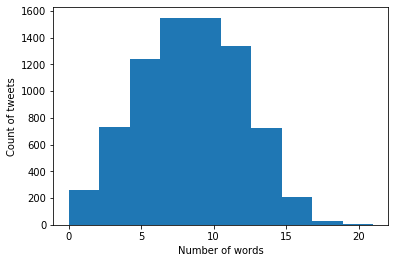

In [72]:
#checking distrubtion of length of tweets
%matplotlib inline

len_list=[]
for i in tqdm(train_tweets):
    len_list.append(len(i))

plt.hist(len_list, density=False, bins=10)  
plt.ylabel('Count of tweets')
plt.xlabel('Number of words')

Most tweets have less than 20 words.
Next step is to create a dictionary of words with n dimensions which will be used in the model. Will be using GloVe embedding with 300 dimensions which can be downloaded from https://nlp.stanford.edu/projects/glove/

In [73]:
embeddings_index_glove = {}
f = codecs.open('embeddings/glove.840B.300d.txt', encoding='utf-8')

for line in f:
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index_glove[word] = coefs
f.close()

In [74]:
#spot checking the embedding index dictionary
embeddings_index_glove['hurricane']

array([-0.43674  , -0.10333  ,  0.33635  ,  0.051283 , -0.19348  ,
       -0.20316  , -0.4466   ,  1.0433   ,  0.26677  ,  1.7239   ,
       -0.28369  , -0.26205  , -0.45438  , -0.30005  , -0.61656  ,
        0.62768  , -0.23625  ,  0.91878  ,  0.065177 , -0.63918  ,
        0.12668  ,  0.17995  , -0.19695  ,  0.19099  , -0.10736  ,
       -0.50168  , -0.55079  , -0.19555  ,  0.1151   , -0.017492 ,
        0.091201 , -0.78987  , -0.43777  ,  0.15285  ,  0.053872 ,
        0.020404 , -0.18169  ,  0.072808 , -0.28677  ,  0.13125  ,
       -0.11851  ,  0.077099 ,  0.36826  , -0.30647  ,  0.061576 ,
       -0.39104  , -0.082649 , -0.37517  ,  0.19079  , -0.020282 ,
       -0.30688  ,  0.12898  ,  0.20518  ,  0.42767  , -1.0231   ,
        0.068287 ,  0.15214  , -0.12757  , -0.020682 ,  0.045102 ,
       -0.32932  ,  0.39246  , -0.062813 ,  0.20911  , -0.20522  ,
        0.079021 , -0.12221  ,  0.61051  , -0.25953  ,  0.39264  ,
        0.2195   ,  0.31411  , -0.308    ,  0.38777  ,  0.4542

In [83]:
MAX_LEN_OF_TWEET = 20
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.2
TEST_SPLIT = 0.1

tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(train_tweets)
train_sequences=tokenizer_obj.texts_to_sequences(train_tweets)
train_tweet_pad = pad_sequences(train_sequences,maxlen=MAX_LEN_OF_TWEET)
word_index = tokenizer_obj.word_index
is_disaster = np.array(df['target'])


num_validation_sample=int(VALIDATION_SPLIT*train_tweet_pad.shape[0])
x_val_pad = train_tweet_pad[:num_validation_sample]
y_val = is_disaster[:num_validation_sample]
x_train_pad = train_tweet_pad[num_validation_sample:] 
y_train = is_disaster[num_validation_sample:]

num_test_sample=int(TEST_SPLIT*x_train_pad.shape[0])
x_test_pad = train_tweet_pad[:num_test_sample]
y_test = is_disaster[:num_test_sample]
x_train_pad = x_train_pad[num_test_sample:] 
y_train = y_train[num_test_sample:]



holdout_sequences=tokenizer_obj.texts_to_sequences(holdout_tweets)
holdout_tweet_pad = pad_sequences(holdout_sequences,maxlen=MAX_LEN_OF_TWEET)
x_holdout = holdout_tweet_pad


print("training set is" , x_train_pad.shape)
print("validation set set is",x_val_pad.shape)
print("testing set for model accuracy set is",x_test_pad.shape)
print("holdout set for submission is",x_holdout.shape)

training set is (5482, 20)
validation set set is (1522, 20)
testing set for model accuracy set is (609, 20)
holdout set for submission is (3263, 20)


## Creating an Embedding Matrix

In [84]:
num_words =len(word_index)+1
embedding_matrix = np.zeros((num_words,EMBEDDING_DIM))
for word, i in word_index.items():
  if i>num_words:
    continue
  embedding_vector = embeddings_index_glove.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

## Training 

In [85]:
model = Sequential()
embedding_layer = Embedding(num_words,EMBEDDING_DIM,input_length=MAX_LEN_OF_TWEET, weights=[embedding_matrix],trainable=False)

model.add(embedding_layer)
model.add(Dropout(0.3))

model.add(Dense(32,activation='relu'))
model.add(Bidirectional(LSTM(64,return_sequences= True)))
model.add(Bidirectional(LSTM(64,return_sequences= True)))
model.add(Bidirectional(LSTM(64,return_sequences= True)))
model.add(Bidirectional(LSTM(64,return_sequences= True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

print('Summary of built model ..')
print(model.summary())

Summary of built model ..
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 300)           4385400   
_________________________________________________________________
dropout_4 (Dropout)          (None, 20, 300)           0         
_________________________________________________________________
dense_6 (Dense)              (None, 20, 32)            9632      
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 20, 128)           49664     
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 20, 128)           98816     
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 20, 128)           98816     
_________________________________________________________________
bidirectional_13 (Bidirectio

Assign the model.fit() method to a variable, which will store the Training, Validation Loss and Accuracy for each epoch. 


In [86]:
history = model.fit(x_train_pad,y_train,batch_size=128,epochs=20,validation_data=(x_val_pad,y_val),verbose=2)

Epoch 1/20
43/43 - 46s - loss: 0.5716 - accuracy: 0.7231 - val_loss: 0.4527 - val_accuracy: 0.8029
Epoch 2/20
43/43 - 39s - loss: 0.4783 - accuracy: 0.7904 - val_loss: 0.4373 - val_accuracy: 0.8127
Epoch 3/20
43/43 - 49s - loss: 0.4520 - accuracy: 0.8024 - val_loss: 0.4350 - val_accuracy: 0.8187
Epoch 4/20
43/43 - 45s - loss: 0.4459 - accuracy: 0.8081 - val_loss: 0.4467 - val_accuracy: 0.8068
Epoch 5/20
43/43 - 37s - loss: 0.4406 - accuracy: 0.8116 - val_loss: 0.4442 - val_accuracy: 0.8081
Epoch 6/20
43/43 - 44s - loss: 0.4216 - accuracy: 0.8207 - val_loss: 0.4636 - val_accuracy: 0.8022
Epoch 7/20
43/43 - 29s - loss: 0.4200 - accuracy: 0.8200 - val_loss: 0.4425 - val_accuracy: 0.8114
Epoch 8/20
43/43 - 34s - loss: 0.4118 - accuracy: 0.8267 - val_loss: 0.4487 - val_accuracy: 0.8114
Epoch 9/20
43/43 - 37s - loss: 0.4068 - accuracy: 0.8260 - val_loss: 0.4460 - val_accuracy: 0.8081
Epoch 10/20
43/43 - 52s - loss: 0.4000 - accuracy: 0.8256 - val_loss: 0.4679 - val_accuracy: 0.8088
Epoch 11/

## Evaluating the Model on Test Set

**Score** is the evaluation of the loss function for a given input.

**Accuracy** How accurate your model's prediction is compared to the true data.

In [87]:
loss_score,accuracy_score = model.evaluate(x_test_pad,y_test,batch_size=128)
print('Test Loss score ',loss_score)
print('Test Accuracy score ',accuracy_score)

5/5 [==============================] - 1s 209ms/step - loss: 0.5462 - accuracy: 0.8046
Test Loss score  0.5461757183074951
Test Accuracy score  0.8045976758003235


## Testing the Model on Sample data


In [88]:
test_sample_1= 'hurricane in chennai'
test_sample_2= 'beware world ablaze sierra leone'
test_sample_3 = 'wild fire happening in bangalore '

test_samples = [test_sample_1,test_sample_2,test_sample_3]
test_sample_tokens = tokenizer_obj.texts_to_sequences(test_samples)
test_sample_tokens_pad = pad_sequences(test_sample_tokens,maxlen=20)

#predict
model.predict(x=test_sample_tokens_pad)

array([[0.7588929 ],
       [0.2677086 ],
       [0.99293923]], dtype=float32)

In [89]:
sample_submission = pd.read_csv("sample_submission.csv")
(model.predict(x_holdout)>0.5).astype(int).shape
sample_submission.shape
x_holdout.shape

(3263, 20)

In [90]:
#8. generating submission file  
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission['target']=(model.predict(x_holdout)>0.5).astype(int)
sample_submission.to_csv('submission0407_LSTM_v4.csv',index=False)